### BigQuery에서 불러오기 (data mart)

In [ ]:
#%pip install google-cloud-bigquery
#%pip install db-dtypes
#%pip install pandas-gbq

In [ ]:
query = f"""
with join_rn as (SELECT o.user_id,
                      order_items_id,
                      sess_created_at,
                      order_created_at,
                      shipped_at,
                      session_id,
                      event_id
                FROM (select `org_data.events`.user_id,
                      `org_data.events`.event_type,
                      `org_data.events`.created_at `sess_created_at`,
                      `org_data.events`.session_id,
                      `org_data.events`.id `event_id`,
                      row_number() over(partition by cast(`org_data.events`.user_id AS string) order by `org_data.events`.created_at) rn
                      from `org_data.events`
                      where `org_data.events`.event_type='purchase') e
              inner join (select user_id,
                        `org_data.order_items`.id `order_items_id`,
                        `org_data.order_items`.created_at `order_created_at`,
                        `org_data.order_items`.shipped_at `shipped_at`,
                        row_number() over(partition by `org_data.order_items`.user_id order by `org_data.order_items`.created_at) rn
                        from `org_data.order_items`) o
              on e.user_id=o.user_id
                and e.rn = o.rn
)

select 
  uoe.* EXCEPT(`inventory_item_id`, `product_id`),
  iv.id `inventory_item_id`,
  iv.product_id,
  iv.product_category `category`,
  iv.product_brand `brand`,
  iv.product_name,
  CAST(iv.created_at AS DATE) `inventory_created_at`,
  CAST(sold_at AS DATE) `inventory_sold_at`,
  iv.cost
from
  (select 
    uo.*,
    oi.id `order_items_id`,
    oi.product_id,
    oi.inventory_item_id,
    oi.status,
    oi.sale_price,
    oi.created_at `order_created_at`,
    oi.shipped_at,
    oi.delivered_at,
    oi.returned_at,
    e.id `event_id`,
    e.session_id,
    e.sequence_number,
    e.user_id `login_user_id`,
    e.created_at `sess_created_at`,
    e.traffic_source `sess_traffic_source`,
    e.uri,
    e.event_type,
    e.ip_address,
    e.state `sess_state`,
    e.city `sess_city`
  from
    (select u.id `user_id`,
      u.age,
      u.gender,
      u.state `account_state`,
      u.city `account_city`,
      u.country `account_country`,
      u.latitude,
      u.longitude,
      u.traffic_source `account_traffic_source`,
      CAST(u.created_at AS DATE) `account_created_at`,
      o.order_id,
    FROM `org_data.users` u
    FULL OUTER JOIN `org_data.orders` o
        on o.user_id=u.id) uo
  FULL OUTER JOIN `org_data.order_items` oi
    on oi.user_id=uo.user_id and oi.order_id=uo.order_id
  FULL OUTER JOIN join_rn
    on join_rn.user_id=uo.user_id
    and join_rn.order_items_id=oi.id
  FULL OUTER JOIN `org_data.events` e
    on (uo.user_id=e.user_id
    and join_rn.event_id=e.id
    and e.event_type='purchase')
  where e.session_id not in (select session_id
                          from join_rn
                          where join_rn.shipped_at < join_rn.order_created_at)    --created_at 보다 과거인 shipped을 갖는 세션은 제거
    and (
        ((oi.shipped_at >= oi.created_at) or (oi.shipped_at is null))          --shipped 정보가 있으면 created_at 보다 클 경우인 주문만
          or ((uo.account_created_at is null) and (e.created_at is not null))  --비회원, 세션만 존재
        )
    or ((uo.account_created_at is not null) and (oi.created_at is null))          --회원, 주문 null (세션 유무 상관없음)
  ) uoe
FULL OUTER JOIN `org_data.inventory_items` iv
  on iv.id=uoe.inventory_item_id
  """

In [ ]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("./looker-ecommerce-e30fc40090ce.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials = credentials, 
                         project = credentials.project_id)

# 데이터 조회 예시 쿼리문 
# FROM절 프로젝트명.데이터셋명.테이블명
query = query
check = client.query(query).to_dataframe()
check

,user_id,age,gender,account_state,account_city,account_country,latitude,longitude,account_traffic_source,account_created_at,...,sess_state,sess_city,inventory_item_id,product_id,category,brand,product_name,inventory_created_at,inventory_sold_at,cost
0,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,Chungcheongnam-do,Asan City,<NA>,<NA>,None,None,None,NaT,NaT,NaN
1,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,North Carolina,Cary,<NA>,<NA>,None,None,None,NaT,NaT,NaN
2,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,Nouvelle-Aquitaine,Le Gua,<NA>,<NA>,None,None,None,NaT,NaT,NaN
3,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,Florida,New Port Richey East,<NA>,<NA>,None,None,None,NaT,NaT,NaN
4,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,Pennsylvania,York,<NA>,<NA>,None,None,None,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466226,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,280837,1381,Sweaters,Coupe Collection,Coupe Collection Women's Abel Cardigan,2023-10-18,NaT,21.552650
2466227,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,446736,13096,Swim,Beach Joy,Black Halter Swim Dress,2019-09-27,2019-11-21,16.447431
2466228,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,153320,13143,Swim,Beach Joy,Black Stripes Sexy Halter Retro Vintage One-Pi...,2021-09-26,2021-10-19,15.007831
2466229,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,314490,530,Tops & Tees,Comfort Colors,Chouinard Women's Long Sleeve Thermal T-Shirt....,2021-11-13,2022-01-05,8.154560


In [ ]:
check.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466231 entries, 0 to 2466230
Data columns (total 37 columns):
 #   Column                  Non-Null Count    Dtype              
---  ------                  --------------    -----              
 0   user_id                 165843 non-null   Int64              
 1   age                     165843 non-null   Int64              
 2   gender                  165843 non-null   object             
 3   account_state           165843 non-null   object             
 4   account_city            165843 non-null   object             
 5   account_country         165843 non-null   object             
 6   latitude                165843 non-null   float64            
 7   longitude               165843 non-null   float64            
 8   account_traffic_source  165843 non-null   object             
 9   account_created_at      165843 non-null   dbdate             
 10  order_id                145887 non-null   Int64              
 11  order_items

In [ ]:
# check.to_csv('./looker_(datetime).csv', index=False)

In [1]:
import pandas as pd
import numpy as np

In [ ]:
df = check.copy()

In [24]:
# 형변환
def convert_type(df):
    for col in df.columns:
        if '_at' in col:    # 시간 데이터
            df = df.assign(**{col:pd.to_datetime(df[col], format='ISO8601')})
            print('[+] {0:<30} >>> datetime'.format(col))
        elif '_id' in col:  # id 컬럼 -> obj형으로
            df = df.assign(**{col:df[col].astype('object')})
            print('[+] {0:<30} >>> object'.format(col))
    return df
df = convert_type(df)

[+] user_id                        >>> object
[+] account_created_at             >>> datetime
[+] order_id                       >>> object
[+] order_items_id                 >>> object
[+] order_created_at               >>> datetime
[+] shipped_at                     >>> datetime
[+] delivered_at                   >>> datetime
[+] returned_at                    >>> datetime
[+] event_id                       >>> object
[+] session_id                     >>> object
[+] login_user_id                  >>> object
[+] sess_created_at                >>> datetime
[+] inventory_item_id              >>> object
[+] product_id                     >>> object
[+] inventory_created_at           >>> datetime
[+] inventory_sold_at              >>> datetime


In [25]:
df.info(show_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466231 entries, 0 to 2466230
Data columns (total 37 columns):
 #   Column                  Non-Null Count    Dtype              
---  ------                  --------------    -----              
 0   user_id                 165843 non-null   object             
 1   age                     165843 non-null   float64            
 2   gender                  165843 non-null   object             
 3   account_state           165843 non-null   object             
 4   account_city            164274 non-null   object             
 5   account_country         165843 non-null   object             
 6   latitude                165843 non-null   float64            
 7   longitude               165843 non-null   float64            
 8   account_traffic_source  165843 non-null   object             
 9   account_created_at      165843 non-null   datetime64[ns]     
 10  order_id                145887 non-null   object             
 11  order_items

In [7]:
order_items = pd.read_csv('./Looker Ecommerce BigQuery Dataset/order_items.csv', low_memory=False)
events = pd.read_csv('./Looker Ecommerce BigQuery Dataset/events.csv', low_memory=False)
users = pd.read_csv('./Looker Ecommerce BigQuery Dataset/users.csv', low_memory=False)

In [33]:
import matplotlib.pyplot as plt
# object / int, float (datetime) 따라서 hist 그래프 만드는 함수 만들기
def get_3_hist(data:pd.DataFrame, columns:list=None):
    """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

    Args:
        data (pd.DataFrame): 데이터프레임
        columns (list): 컬럼 리스트
    """
    
    if columns==None:
        columns = data.columns.to_list()

    col_len = len(columns)
    if col_len < 3:
        col_len = 3
    
    plt.figure(figsize=(16, 5 * (col_len // 3)))

    for i, col in enumerate(columns):
        # 서브플롯 위치 설정
        plt.subplot(col_len // 3 + (col_len % 3 > 0), 3, i + 1)

        if 'id' in col.lower():
            df = data[col].value_counts(dropna=True)[:10]
            col += ' Top 10'

            df.plot.bar()
            """            
            for x,y in df.items():
                plt.text(x,y,y)
            """
        elif data[col].dtype == 'object':
            df = data[col].value_counts()
            if len(df) > 10:
                df = pd.concat([df[:9], pd.Series({'extra':df[9:].sum()})])
            plt.pie(df, autopct='%.1f%%', labels=df.index)
            # plt.legend(df.index, loc='upper left')
        else:
            try:
                plt.hist(data[col])
            except:
                plt.hist(data[col].dropna())
                col += ' (dropna)'

        plt.title(col)
        plt.xticks(rotation=90)
    
    # 전체 그림 표시
    plt.tight_layout()
    plt.show()

In [15]:
col_list = ['user_id', 'age', 'gender', 
            'account_country', 'account_traffic_source', 'account_created_at', 
            'order_id', 'order_items_id', 'status',
            'sale_price', 'order_created_at', 'event_id', 
            'sequence_number', 'login_user_id', 'sess_created_at', 
            'sess_traffic_source', 'event_type', 'inventory_item_id', 
            'product_id', 'category', 'brand', 
            'inventory_created_at', 'inventory_sold_at', 'cost']

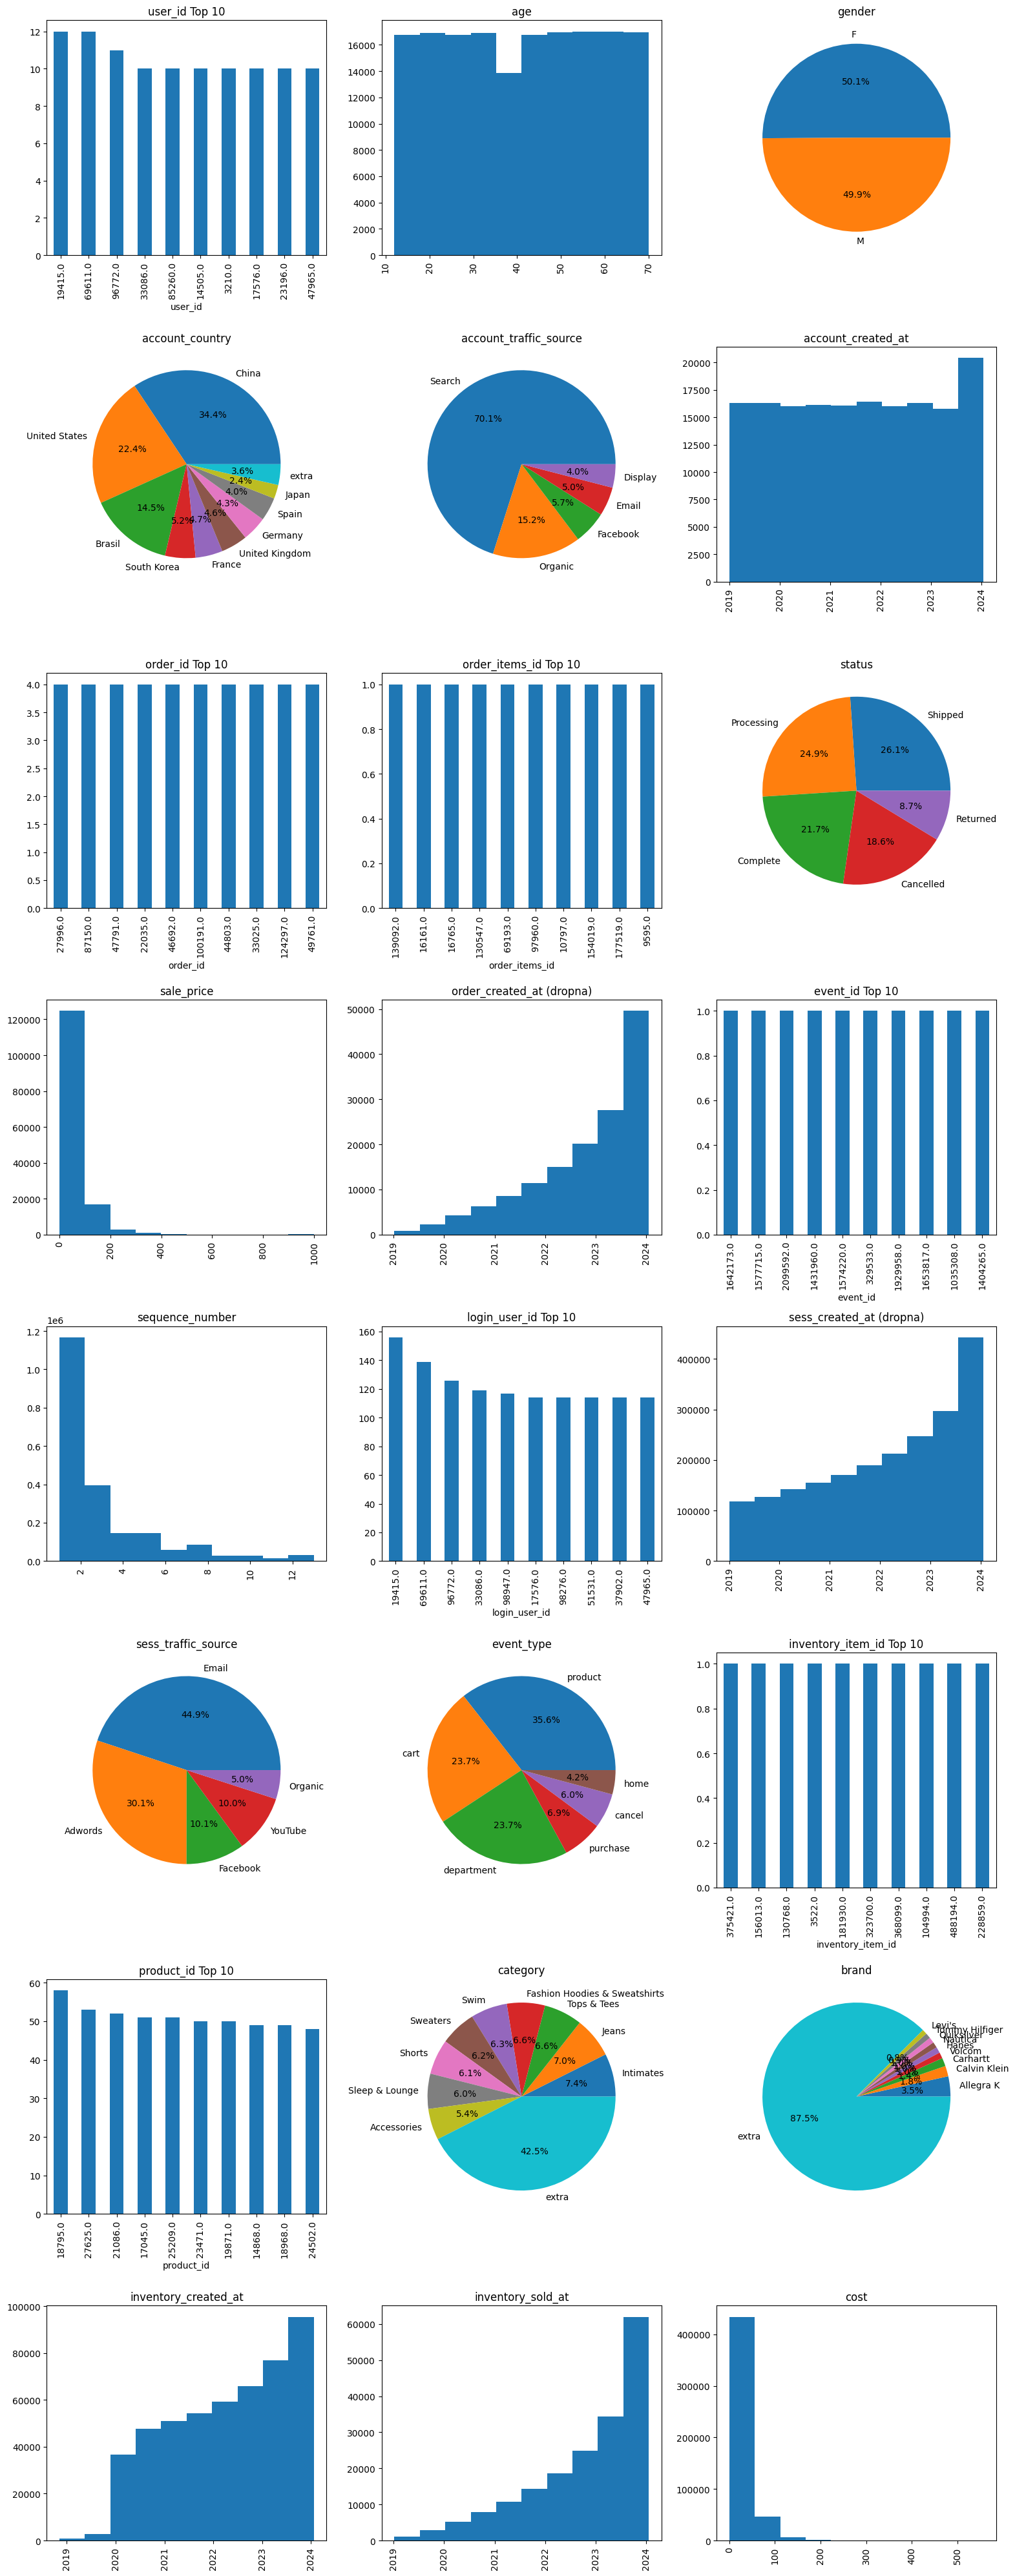

In [34]:
get_3_hist(df, columns=col_list)

status 수 일치

In [5]:
df.status.value_counts(dropna=False)

status
NaN           2320344
Shipped         38042
Processing      36388
Complete        31679
Cancelled       27090
Returned        12688
Name: count, dtype: int64

In [ ]:
order_items[(order_items.created_at <= order_items.shipped_at) | (order_items.shipped_at.isna())].status.value_counts(dropna=False)

status
Shipped       38042
Processing    36388
Complete      31679
Cancelled     27090
Returned      12688
Name: count, dtype: int64

event_type 수 일치

In [ ]:
events.event_type.value_counts()

event_type
product       845607
cart          595994
department    595323
purchase      181759
cancel        125568
home           87712
Name: count, dtype: int64

In [ ]:
df.event_type.value_counts()

event_type
product       747397
cart          497784
department    497113
purchase      145887
cancel        125568
home           87708
Name: count, dtype: int64

In [ ]:
# 제거되는 세션의 event_type 수
events[~events.session_id.isin(df.session_id.unique())].event_type.value_counts(dropna=False)

event_type
cart          98210
department    98210
product       98210
purchase      35872
home              4
Name: count, dtype: int64

In [ ]:
events.event_type.value_counts() - df.event_type.value_counts()

event_type
product       98210
cart          98210
department    98210
purchase      35872
cancel            0
home              4
Name: count, dtype: int64

제거된 유저: 100,000 - 96,874 = 3126

In [ ]:
# 유저
df.user_id.nunique()

96874

주문한 유저 수 일치: 76,918명 (전처리 전 80,044명)

In [35]:
order_items.user_id.nunique()

80044

In [ ]:
# 주문한 유저
order_items[(order_items.created_at <= order_items.shipped_at) | (order_items.shipped_at.isna())].user_id.nunique()

76918

In [ ]:
# 주문한 유저
df[~df.order_id.isna()].user_id.nunique()

76918

가입만 한 유저: 96,874 - 76,918 = 19,956명

In [ ]:
96874 - 76918

19956

In [ ]:
# 가입은 했지만 세션 없는 유저 -> 주문도 안함
users[(~users.id.isin(events.user_id.unique()))].id.nunique()

19956

고유값을 갖는 event_id와 order_items_id가 하나씩만 존재

In [ ]:
df.event_id.value_counts()[:5]

event_id
1642173    1
1577715    1
2099592    1
1431960    1
1574220    1
Name: count, dtype: Int64

In [ ]:
df.order_items_id.value_counts()[:5]

order_items_id
139092    1
16161     1
16765     1
130547    1
69193     1
Name: count, dtype: Int64